In [1]:
# Loading in libraries necessary for CNN
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, BatchNorm1d, ConvTranspose1d, KLDivLoss
from torch.optim import Adam, SGD, Adagrad, RMSprop, SparseAdam, LBFGS, Adadelta
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot
import time
import torch.nn.functional as F
import nmrsim
from nmrsim import plt
from itertools import product
import statistics
from tqdm import tqdm

# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
#print(torch.cuda.get_device_name(0))

Using cuda device


In [2]:
#Checking how many files are in repository for training, testing, and validation
files = glob.glob('./Spectral_Data/spectral_data/400MHz/*.csv')
print('Total number of files: ', len(files))

Total number of files:  1294


In [3]:
class GHzData(Dataset):
    def __init__(self):
        # Data loading starting with list of csv strings
        self.files = glob.glob(os.path.join('./Spectral_Data/spectral_data/400MHz', 
                                                       'spectral_data_*.csv'))

        self.y_60 = [] # Establishes a list for 60 MHz data
        self.y_400 = [] # Establishes a list for 400 MHz data

        for self.file in self.files: # For loop for each file in files
            self.df = pd.read_csv(self.file) # Reads each into a pandas dataframe
            self.array_60 = self.df['60MHz_intensity'].to_numpy() # Takes 60MHz intensity to np
            self.array_400 = self.df['400MHz_intensity'].to_numpy() # Takes 400MHz intensity to np
            self.y_60.append(self.array_60) # Appends all arrays to 60MHz list
            self.y_400.append(self.array_400) # Appends all arrays to 400MHz list
            
        # Creates a 60 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_60 = torch.Tensor(self.y_60).float().unsqueeze(1).to(device)        

        # Creates a 400 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_400 = torch.Tensor(self.y_400).float().unsqueeze(1).to(device)
        
        # Track the length of number of samples in frame
        self.num_samples = len(self.y_60)

    def __getitem__(self, index): # establishes an index for the tensors
        return self.tensor_60[index], self.tensor_400[index]
    
    def __len__(self): # Returns variable number of samples
        return self.num_samples
    
  

In [4]:
features = 5500
encode = 512
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=5500, out_features=encode)
        self.enc2 = nn.Linear(in_features=encode, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=encode)
        self.dec2 = nn.Linear(in_features=encode, out_features=5500)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # add an additional dimension to the input tensor
        x = x.view(-1, 5500)
        x = x.unsqueeze(1)
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)

        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        #print(x.shape)
        reconstruction = torch.sigmoid(self.dec2(x))
        reconstruction = reconstruction.unsqueeze(1)
        #print(reconstruction.shape)
        return reconstruction, mu, log_var

In [5]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data, _ = data
        data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [6]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [7]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [8]:
num_epochs = 20
lr = 0.007
train_batch_size = 32

In [9]:
model = LinearVAE().to(device)
optimizer = Adam(model.parameters(), lr=lr)
#criterion = nn.BCELoss(reduction='mean')
criterion = nn.KLDivLoss()

In [10]:
# Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_400,
                                                    test_size=0.1)

# Splits train data into validation data
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                      test_size=0.1)
# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)
valid_dataset = TensorDataset(valid_X, valid_y)

# Batch size change to higher batch sizes
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

/home/garrettreinhard/miniconda3/envs/isotope/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


In [ ]:
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    train_epoch_loss = fit(model, train_dataloader)
    val_epoch_loss = validate(model, valid_dataloader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    if(int(epoch) % 10) == 0:
        print(f'Epoch {epoch} Training loss: {train_epoch_loss:.4f}')   
        print(f'Epoch {epoch} Valid loss: {val_epoch_loss:.4f}')   

/home/garrettreinhard/miniconda3/envs/isotope/lib/python3.7/site-packages/torch/nn/functional.py:2917: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0 Training loss: 0.9229
Epoch 0 Valid loss: 0.0357
Epoch 10 Training loss: -0.0030
Epoch 10 Valid loss: -0.0009


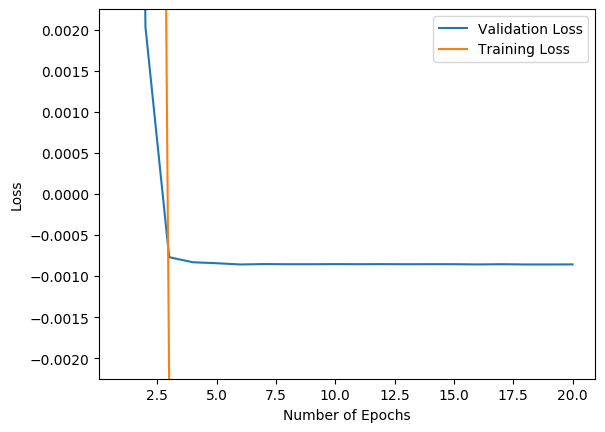

In [23]:
x = np.linspace(1, num_epochs, num_epochs)

fig, ax = matplotlib.pyplot.subplots()
ax.plot(x, val_loss, label='Validation Loss')
ax.plot(x, train_loss, label='Training Loss' )
#matplotlib.pyplot.xlim([5, 25])
matplotlib.pyplot.ylim([-statistics.mean(val_loss)*2, statistics.mean(val_loss)*2])
matplotlib.pyplot.xlabel('Number of Epochs')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, _ in test_dataloader:
        print(inputs.shape)
        inputs = inputs.squeeze(1)
        print(inputs.shape)

        reconstruction, _, _ = model(inputs)

#predictions_numpy = reconstruction.cpu().numpy()
#predictions_numpy = np.concatenate(predictions_numpy)
#predictions_numpy.shape
#pred = pd.DataFrame(predictions_numpy)

torch.Size([128, 1, 5500])
torch.Size([128, 5500])
torch.Size([2, 1, 5500])
torch.Size([2, 5500])


In [ ]:
df_60 = pd.read_csv('./Spectral_Data/spectral_data/400MHz/Test_Data/spectral_data_12_00052.csv')
df_x = df_60['60MHz_intensity']
df_x = df_x.to_numpy()
df_x = torch.Tensor(df_x).to(device)

In [ ]:
reconstruction, _, _, = model(df_x)
reconstruction_numpy = reconstruction.detach().cpu().numpy()

In [ ]:
reconstruction_numpy

array([[[1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)

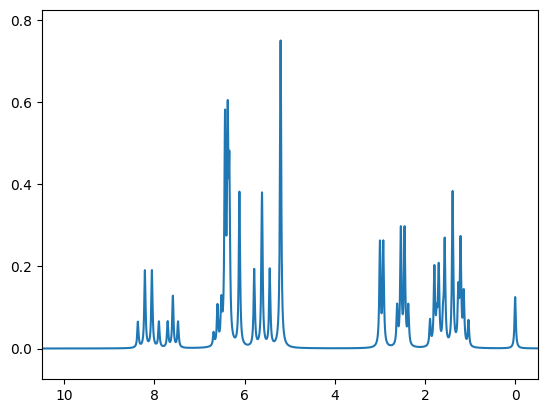

(0       -0.500000
 1       -0.498000
 2       -0.495999
 3       -0.493999
 4       -0.491999
           ...    
 5495    10.491999
 5496    10.493999
 5497    10.495999
 5498    10.498000
 5499    10.500000
 Name: 60MHz_ppm, Length: 5500, dtype: float64,
 0       0.000332
 1       0.000334
 2       0.000335
 3       0.000337
 4       0.000338
           ...   
 5495    0.000094
 5496    0.000094
 5497    0.000094
 5498    0.000094
 5499    0.000094
 Name: 60MHz_intensity, Length: 5500, dtype: float64)

In [ ]:
nmrsim.plt.mplplot_lineshape(df_60['60MHz_ppm'], df_60['60MHz_intensity'], limits=(-0.5, 10.5))

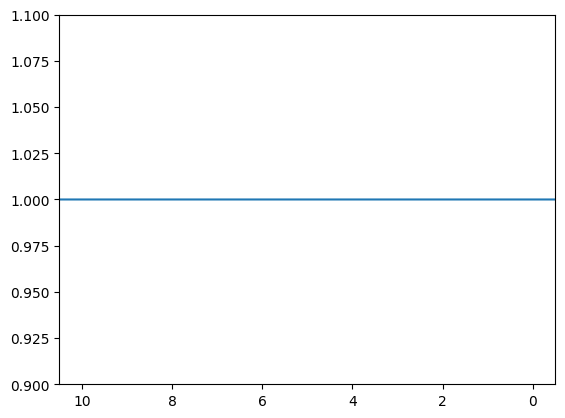

(array([-0.5       , -0.49799964, -0.49599927, ..., 10.49599927,
        10.49799964, 10.5       ]),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [ ]:
x = np.linspace(-.5,10.5,5500)
y = reconstruction_numpy[0][0]


nmrsim.plt.mplplot_lineshape(x, y, limits=(-0.5, 10.5))

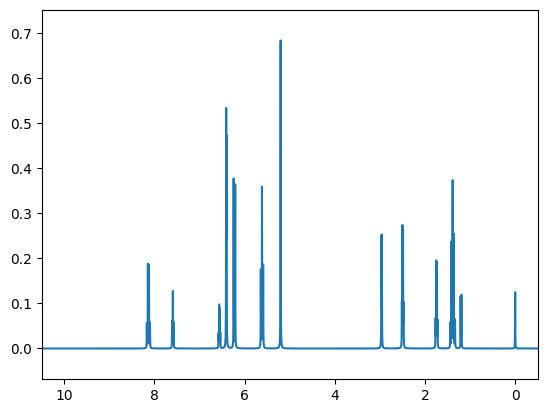

(array([-0.5       , -0.49799964, -0.49599927, ..., 10.49599927,
        10.49799964, 10.5       ]),
 array([7.42848547e-06, 7.46112740e-06, 7.49409595e-06, ...,
        2.11011925e-06, 2.10779345e-06, 2.10547204e-06]))

In [ ]:
nmrsim.plt.mplplot_lineshape(np.array(df_60['400MHz_ppm']), np.array(df_60['400MHz_intensity']), limits=(-0.5, 10.5))